In [6]:
#Code Prototype for 1D use on EXCLAIM Project with one sensor, code by Joaquin Matticoli (joaquinmatticoli@gmail.com)

In [7]:
import numpy as np
import filterpy
from filterpy.kalman import KalmanFilter as kf
from filterpy.kalman import predict
from filterpy.kalman import update
from numpy.random import randn
# from filterpy.common import Q_continuous_white_noise
import matplotlib.pyplot as plt
import filterpy.stats as stats
import math
from math import sqrt

In [8]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1]) #Not neccesary, just a neat way to have variables as gaussians

np.random.seed(24) # Makes same random numbers appear every iteration, remove this if you want to test different random numbers

def print_gh(predict, update, z1, K):
    predict_template = '{: 7.3f} {: 8.3f}'
    update_template = '{:.3f}\t{: 7.3f} {: 7.3f}     {:.3f}'

    print(predict_template.format(predict[0], predict[1]),end='\t')
    print(update_template.format(z1, update[0], update[1], K))

In [9]:
class PayloadSimulation(object): #Simulates movement while we don't have real sensor data being inputed
    def __init__(self, x0=0, angular_velocity2=1,
                 measurement1_var=0.0, measurement2_var = 0.0,
                 process_var=0.0):
        """ x0 : initial orientation
            angular_velocity: (+=counterclockwise, -=clockwise)
            measurement_var: variances in measurement deg^2
            process_var: variance in process (deg/s)^2
        """
        self.x = x0
        self.angular_velocity = angular_velocity2
        self.meas1_std = sqrt(measurement1_var)
        self.meas2_std = sqrt(measurement2_var)
        self.process_std = sqrt(process_var)

    def move(self, dt=1.0):
        """Compute new orientation of the payload in dt seconds."""
        dx = self.angular_velocity + abs(randn()*self.process_std)
        self.x += dx * dt

    def sense_position(self):
        """ Returns measurement of new orientation in degrees."""
        measurement = self.x + abs(randn()*self.meas1_std)
        return measurement
    
#     def sense_velocity(self): #Only sensor is position sensor so this isn't needed
#         """ Returns measurement of new angular velocity in deg/sec."""
#         measurement2 = self.angular_velocity + abs(randn()*self.meas2_std)
#         return measurement2

    def move_and_sense(self):
        """ Move payload, and return measurement of new orientation in degrees"""
        self.move()
        return self.sense_position()

In [10]:
printcase = 1 # If set to 1 it will print out the results
plotcase = 1 # If set to 1 it will plot results

#-----------USER INPUT STARTS------------------------------

number_of_variables = 2 #number of variables being measured
number_of_sensors = 1 #number of sensors used
process_var = 25. # variance in the payload's movement, idk what number is good for this??
sensor1_var = 2. # variance in the sensor
x = gaussian(0., 100.)  # payload's initial orientation in deg
angular_velocity = 0.5 # angular velocity in deg/s
dt = 0.5 # time step in seconds
total_time = 30. # Total time passed from beginning to end of experiment

#-----------USER INPUT ENDS--------------------------------

process_model = gaussian(angular_velocity, process_var) # displacement to add to x
n_iter = math.floor(total_time/dt)

    #NOTE: this code will assume that orientation is always increasing/decreasing and not sinusodial because a more complext Kalman filter is needed for those cases
    
# Initializes payload simulation and gets measurements
payload = PayloadSimulation(
    x0=x.mean, 
    angular_velocity2=process_model.mean, 
    measurement1_var=sensor1_var, 
    process_var=process_model.var)

# Runs paylodad simulation; creates list of measurements, NOTE: modify this section if measurements are provided
zs, ztrue = [], []
for _ in range(n_iter):
    zs.append(payload.move_and_sense())
    ztrue.append(payload.x)
finalposition = payload.x #Records final position for table text

PREDICT				UPDATE
     x      var		  z1	    x      var         K
 -0.078  106.251	8.235	  8.081   1.963     0.982
  8.484    8.086	10.629	 10.203   1.603     0.802
 11.883    6.303	17.116	 15.856   1.518     0.759
 19.746    4.046	18.822	 19.128   1.338     0.669
 22.761    2.824	27.346	 25.445   1.171     0.585
 29.961    2.137	33.602	 31.841   1.033     0.517
 36.868    1.712	36.384	 36.645   0.922     0.461
 41.620    1.428	40.346	 41.089   0.833     0.417
 45.955    1.228	48.406	 46.888   0.761     0.380
 51.924    1.081	48.966	 50.887   0.702     0.351
 55.750    0.970	56.219	 55.903   0.653     0.327
 60.791    0.885	62.977	 61.461   0.613     0.307
 66.447    0.819	65.703	 66.231   0.581     0.291
 71.186    0.767	66.808	 69.972   0.555     0.277
 74.762    0.727	68.245	 73.024   0.533     0.267
 77.584    0.696	69.942	 75.610   0.517     0.258
 79.911    0.673	80.015	 79.937   0.503     0.252
 84.241    0.655	88.739	 85.350   0.493     0.247
 89.798    0.641	87.827	 89.320   0.

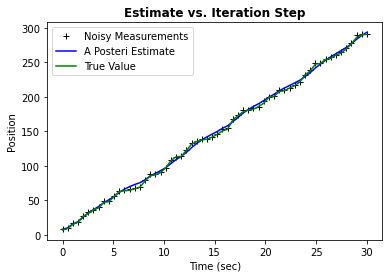

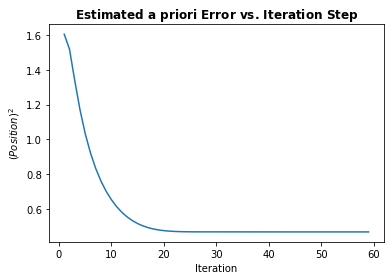

In [11]:
def plotstuff():
    plt.figure() #Plots KF estimate vs true value
    plt.plot(np.linspace(0,total_time,len(zs)),zs,'k+',label='Noisy Measurements')
#     plt.plot(np.linspace(0,total_time,len(x1)),x1,'r*',label='A Priori Estimate')
    plt.plot(np.linspace(0,total_time,len(xhat)),xhat,'b-',label='A Posteri Estimate')
    plt.plot(np.linspace(0,total_time,len(ztrue)),ztrue,color='g',label='True Value')
    plt.legend()
    plt.title('Estimate vs. Iteration Step', fontweight='bold')
    plt.xlabel('Time (sec)')
    plt.ylabel('Position')
    
    plt.figure() # Plots variance over time
    valid_iter = range(1,n_iter) # Phat not valid at step 0
    plt.plot(valid_iter,Phat[valid_iter],label='A Posteri Error Estimate')
    plt.title('Estimated $\it{\mathbf{a \ priori}}$ Error vs. Iteration Step', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('$(Position)^2$')
    #plt.setp(plt.gca(),'ylim',[0,.01])
    plt.show()

# x1 = np.zeros(n_iter)
Phat = np.zeros(n_iter)
xhat = np.zeros(n_iter)
counter = 0
if printcase == 1: #Sets up title for table
    print('PREDICT\t\t\t\tUPDATE')
    print('     x      var\t\t  z1\t    x      var         K')

# perform Kalman filter on measurement(s) z
f = kf(dim_x=number_of_variables, dim_z=number_of_sensors) # Initializes Kalman filter function
f.F = np.array([[1., dt], [0., 1.]]) #correct for calculating position from position and velocity
f.H = np.array([[1., 0.]]) #this is for first sensor measuring position
f.x = np.array([[x.mean], [angular_velocity+randn()]])
f.Q *= np.array([[(dt**3)/3, (dt**2)/2],
                [(dt**2)/2,  dt      ]]) * 0.02  # Arbitrary 0.02; This is the same as running the Q_continuous_white_noise
f.P = np.diag([x.var,process_var]) #Variance
f.R = sensor1_var  #Noise in sensors

for i in range(n_iter):     #Runs Kalman filter through each iteration
    f.predict()
    prior = gaussian(f.x_prior[0,0], f.P_prior[0,0])
    f.update(zs[i])
    x = gaussian(f.x[0,0], f.P[0,0])
    if printcase == 1:
        print_gh(prior, x, zs[i], f.K[0,0])
    if plotcase == 1:
#         x1[i] = prior.mean
        xhat[i] = x.mean
        Phat[i] = x.var

if printcase == 1:
    print()
    print('final estimate:           {:10.3f}'.format(x.mean))
    print('actual final orientation: {:10.3f}'.format(payload.x))
if plotcase == 1:
    print()
    plotstuff()